In [1]:
import os
import json
import torch
import torchtext as text
import sys
import tqdm
from datasets import load_dataset
import pandas as pd
import string
from torchtext.data import get_tokenizer
from vocab import *
from utils import *
from constants import *
import pickle

from tqdm.notebook import tqdm

In [2]:
dataset = load_dataset("squad")

train = {'passage': [], 'question': [], 'answer': []}
for i in range(len(dataset['train'])):
    datum = dataset['train'][i]
    for j in range(len(datum['answers']['text'])):
        train['passage'].append(datum['context'])
        train['question'].append(datum['question'])
        train['answer'].append(datum['answers']['text'][j])

train = pd.DataFrame(train)

val = {'passage': [], 'question': [], 'answer': []}
for datum in dataset['validation']:
    for elem in datum['answers']['text']:
        ans_id = 0
        val['passage'].append(datum['context'])
        val['question'].append(datum['question'])
        val['answer'].append(elem)

val = pd.DataFrame(val)

Reusing dataset squad (/tmp/xdg-cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
train_short_dic = {'passage': [], 'answer': [], 'question': []}
for idx in range(len(train)):
    row = train.iloc[idx]
    passage, answer, question =  row['passage'].lower(), row['answer'].lower(), row['question'].lower()
    
    prefix, ans, suffix = passage.partition(answer)
    context = ' '.join(prefix.split(' ')[-10:]) + ans + ' '.join(suffix.split(' ')[:10])
    train_short_dic['passage'].append(context)
    train_short_dic['answer'].append(answer)
    train_short_dic['question'].append(question)
train_short = pd.DataFrame(train_short_dic)

In [4]:
val_short_dic = {'passage': [], 'answer': [], 'question': []}
for idx in range(len(val)):
    row = val.iloc[idx]
    passage, answer, question =  row['passage'].lower(), row['answer'].lower(), row['question'].lower()
    
    prefix, ans, suffix = passage.partition(answer)
    context = ' '.join(prefix.split(' ')[-10:]) + ans + ' '.join(suffix.split(' ')[:10])
    val_short_dic['passage'].append(context)
    val_short_dic['answer'].append(answer)
    val_short_dic['question'].append(question)
val_short = pd.DataFrame(val_short_dic)

In [5]:
#Split Val into val and test

val_short = val_short.sample(frac=1).reset_index(drop=True)
test_short = val_short[:10000]
val_short = val_short[10000:]

train_short.to_csv('./data/train_short.csv', index=False)
val_short.to_csv('./data/val_short.csv', index=False)
test_short.to_csv('./data/test_short.csv', index=False)

In [6]:
vocab = load_vocab()

loaded vocab


In [10]:
tokenizer = get_tokenizer('basic_english')
train_short['passage'].apply(lambda x: len(tokenizer(x))).max()

68

In [11]:
def get_processed_short_data(df, tokenizer):
        data = []
        for idx in tqdm(range(len(df))):
            pass_tokens = ['<start>'] + tokenizer(df.iloc[idx]["passage"]) + ['<end>']
            ans_tokens = ['<start>'] + tokenizer(df.iloc[idx]["answer"]) + ['<end>']
            q_tokens = ['<start>'] + tokenizer(df.iloc[idx]["question"]) + ['<end>']

            pass_len = MAX_SHORT_PASSAGE_LEN + 2 # +2 for start and end tokens
            ans_len = MAX_SHORT_ANSWER_LEN + 2
            q_len = MAX_SHORT_QUESTION_LEN + 2

            passage = [vocab(word) for word in pass_tokens]
            answer = [vocab(word) for word in ans_tokens]
            question = [vocab(word) for word in q_tokens]

            # padding to same length
            pass_idxs = torch.zeros(pass_len)
            ans_idxs = torch.zeros(ans_len)
            q_idxs = torch.zeros(q_len)

            pass_idxs[:len(passage)] = torch.FloatTensor(passage)
            ans_idxs[:len(answer)] = torch.FloatTensor(answer)
            q_idxs[:len(question)] = torch.FloatTensor(question)

            data.append((pass_idxs, ans_idxs, q_idxs))
        return data

In [12]:
tokenizer = get_tokenizer("basic_english")
train_short_processed = get_processed_short_data(train_short, tokenizer)
val_short_processed = get_processed_short_data(val_short, tokenizer)
test_short_processed = get_processed_short_data(test_short, tokenizer)

  0%|          | 0/87599 [00:00<?, ?it/s]

  0%|          | 0/24726 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
test_short_processed[0][0].shape

torch.Size([70])

In [14]:
with open('./data/train_short_processed.pickle', 'wb') as train_file:
    pickle.dump(train_short_processed, train_file)

with open('./data/val_short_processed.pickle', 'wb') as val_file:
    pickle.dump(val_short_processed, val_file)

with open('./data/test_short_processed.pickle', 'wb') as test_file:
    pickle.dump(test_short_processed, test_file)

In [2]:
with open('./data/train_short_processed.pickle', 'rb') as train_file:
    temp = pickle.load(train_file)

In [16]:
temp[0][0].shape

torch.Size([70])

### EDA

In [4]:
df = pd.read_csv('./data/train_short.csv')

In [5]:
tokenizer = get_tokenizer('basic_english')

In [6]:
q_lengths = df['question'].apply(lambda x: len(tokenizer(x)))

<AxesSubplot:>

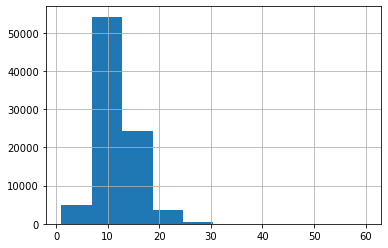

In [8]:
q_lengths.hist()

In [11]:
p_lengths = df['passage'].apply(lambda x: len(tokenizer(x)))

<AxesSubplot:>

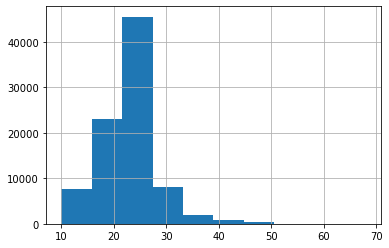

In [12]:
p_lengths.hist()

In [16]:
a_lengths = df['answer'].apply(lambda x: len(tokenizer(str(x))))

<AxesSubplot:>

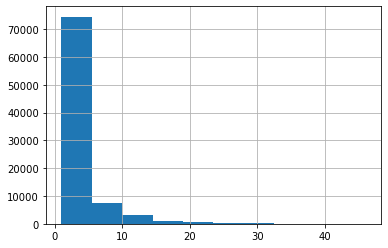

In [17]:
a_lengths.hist()

In [23]:
a_lengths.describe()

count    87599.000000
mean         3.444023
std          3.799090
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         46.000000
Name: answer, dtype: float64

In [21]:
def max_outlier(lengths):
    stats = lengths.describe()
    iqr = stats['75%'] - stats['25%']
    outlier_thresh = 1.75 * iqr + stats['75%']
    return outlier_thresh

In [22]:
max_outlier(q_lengths), max_outlier(p_lengths), max_outlier(a_lengths)

(20.0, 32.0, 9.25)